# Plot Cross-Sections

In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import glob,imp,os,shutil
from pandas.io.json import json_normalize
import pyslha
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from collections import OrderedDict
import seaborn as sns
from scipy.interpolate import interp1d
from IPython.display import display, Markdown

pd.option_context('display.max_columns', -1)

pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')

### Create process dict

In [2]:
processDict = {'sms' : r'$p p \to \tilde{t} \tilde{t}$',
              'dmeft' : r'$p p \to \tilde{\chi} \tilde{\chi}$',
              'smeft_full' : r'$p p \to t \bar{t}$ (NLO)',
              'smeft_bsm' : r'$p p \to t \bar{t}$ (NLO-BSM)',
              'smeft_sm' : r'$p p \to t \bar{t}$ (NLO-SM)'}
# Create a dictionary with keys = dataframe columns and values = (short name, latex name)
varDict = {'mass.5000002' : ('mst',r'$m_{\tilde{t}}$'), 
           'mass.5000012' : ('mchi',r'$m_{\tilde{\chi}}$'),
           'xsec13TeV(fb).-5000002_5000002' : ('xsecst',r'$\sigma(\tilde{t} \tilde{t})$'),
           'xsec13TeV(fb).5000012_5000012' : ('xsecchi',r'$\sigma(\tilde{\chi} \tilde{\chi})$'),
           'xsec13TeV(fb).-6_6' : ('xsectop',r'$\sigma(t \bar{t})$'),
           'pars.1' : ('ydm',r'$y_{DM}$')
             }
shortDict = {x[0] : x[1] for x in varDict.values()}
varDict = {x : y[0] for x,y in varDict.items()}

## Load data

In [3]:
data = {}
for proc in processDict:
    f = '../slhaFiles/%s_slha.pcl' %(proc)
    if os.path.isfile(f):
        data[proc] = pd.read_pickle(f)
        # From now on use only short names
        data[proc].rename(columns=varDict,inplace=True)
        
# For SMS set yDM = 10 (only affects the stop lifetime)
if 'sms' in data:
    ydm = data['sms']['ydm'].tolist()
    data['sms']['width.5000002'] = data['sms']['width.5000002']*((10./data['sms']['ydm'])**2)
    data['sms']['ydm'] = 10.0

### Get all model points

In [4]:
models = []
mCols = ['mst','mchi','ydm']
for dataDF in data.values():
    for row in dataDF[mCols].values:
        m = dict(zip(mCols,row.tolist()))
        if m not in models:
            models.append(m)
print('%i models loaded' %len(models))

223 models loaded


### Get model parameters

In [5]:
parameters = {label : list(set([m[label] for m in models])) for label in mCols}
for k,v in parameters.items():
    if len(v) == 1:
        parameters[k] = v[0]
# print(parameters)

textstr = '\n'.join([r'%s = %s' %(k,v) for k,v in parameters.items() if k not in ['mst','mchi']])
print(textstr)

ydm = 10.0


### Select model

In [6]:
modelFilter = {'ydm' : 10.0}


modelStr = '\n'.join([r'%s = %s' %(shortDict[k],v) for k,v in modelFilter.items()])
for proc in data:
    data[proc] = data[proc].loc[(data[proc][list(modelFilter)] == pd.Series(modelFilter)).all(axis=1)]
    print(proc,len(data[proc]))


sms 206
dmeft 36


### Plot Cross-Sections

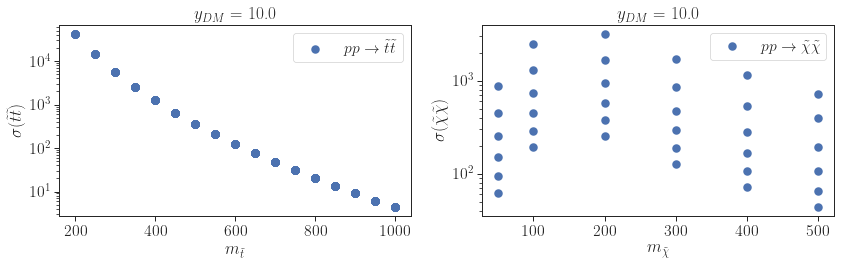

In [7]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
axes = {'sms' : ('mst','xsecst'), 'dmeft' : ('mchi','xsecchi')}
for iproc,proc in enumerate(data.keys()):
    x,y = axes[proc]
    dataDF = data[proc]
    xpts = dataDF[x]
    ypts = dataDF[y]
    ypts = ypts[np.argsort(xpts)]
    xpts = xpts[np.argsort(xpts)]
    ax[iproc].scatter(xpts,ypts,label=processDict[proc],linewidth=3,s=30)
    ax[iproc].set_xlabel(shortDict[x])
    ax[iproc].set_ylabel(shortDict[y])
    ax[iproc].set_yscale('log')
    ax[iproc].legend()
    ax[iproc].set_title(modelStr)

plt.tight_layout()
plt.show()

In [8]:
chiColors = sns.color_palette("flare",10)
stColors = sns.color_palette("crest",10)

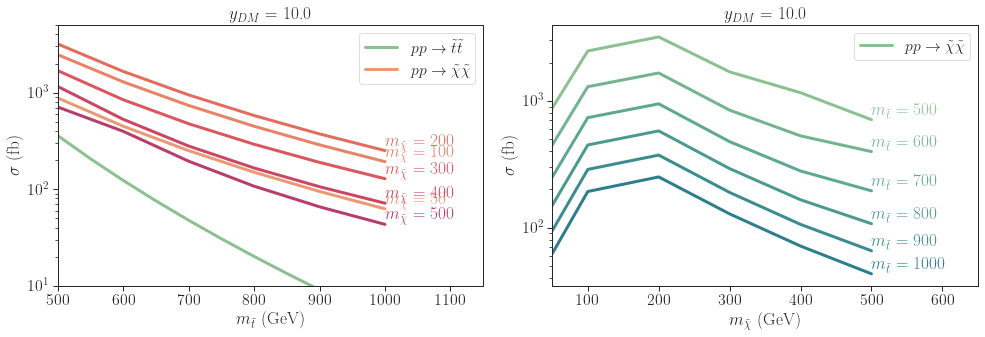

In [10]:
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(14,5))
for iax,ax in enumerate(axes.flat):
    if iax == 0:
        x = 'mst'
        z = 'mchi'
        mainC = stColors
        varC = chiColors
    else:
        x = 'mchi'
        z = 'mst'
        mainC = chiColors
        varC = stColors

        
    # SMS curve
    if iax == 0:
        y = 'xsecst'
        xpts = data['sms'][x]
        ypts = data['sms'][y]
        ypts = ypts[np.argsort(xpts)]
        xpts = xpts[np.argsort(xpts)]    
        ax.plot(xpts,ypts,label=processDict['sms'],linewidth=3,c=mainC[0])
    
    # DM curves
    y = 'xsecchi'
    mVals = sorted(list(data['dmeft'][z].unique()))
    for im,m in enumerate(mVals):
        text = '%s = %1.0f' %(shortDict[z],m)
        dFilter = data['dmeft'][(data['dmeft'][z] == m)]
        xpts = np.array(dFilter[x].tolist())
        ypts = np.array(dFilter[y].tolist())
        ypts = ypts[np.argsort(xpts)]
        xpts = xpts[np.argsort(xpts)]
        label = None
        if im == 0:
            label='%s' %(processDict['dmeft'])
        
        p = ax.plot(xpts,ypts,label=label,linewidth=3,linestyle='-',c=varC[im])
        ax.text(xpts[-1],1.1*ypts[-1],text,c=p[0].get_color())
            
    ax.set_xlabel(shortDict[x]+' (GeV)')
    ax.set_ylabel(r'$\sigma$ (fb)')
    ax.set_yscale('log')
    if iax == 0:
        ax.set_xlim(500,1150)
        ax.set_ylim(1e1,5e3)
    else:
        ax.set_xlim(50,650)
#         ax.vlines(x=200.,ymin=1e1,ymax=1e4)
    ax.legend()
    ax.set_title(modelStr)
plt.tight_layout()
plt.show()